## MSC Data Science Final Project on Chronic Kidney Disease

## Chronic Kidney Disease Prediction Overview

This project is focused on predicting chronic kidney disease (CKD) by analyzing essential medical parameters,including Specific Gravity, Hypertension, Hemoglobin, Diabetes Mellitus, Albumin, Appetite, Red Blood Cell Count, Pus Cell, and more.
By utilizing advanced machine learning models, the system delivers precise predictions to support healthcare professionals in early diagnosis and informed decision-making, ultimately enhancing patient outcomes.

## Importing Required Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb


from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve,
                             classification_report, ConfusionMatrixDisplay, accuracy_score)
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score

from scipy.stats import ttest_rel
import joblib
# Set a seed for reproducibility
SEED = 42
np.random.seed(SEED)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Overview

Raw Dataset of CKD :
    id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]

 CKD Dataset Info:

<class 'pandas.core.frame.D

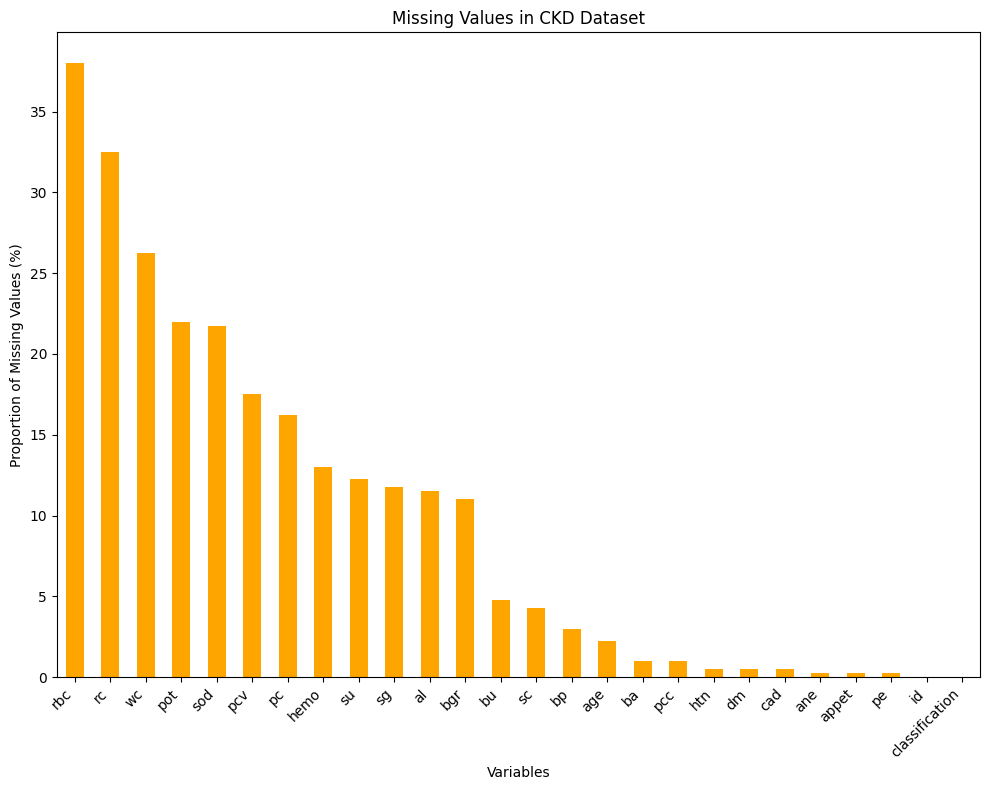

In [3]:
def load_CKDdata(file_path):
    """
    Loading the dataset and displaying basic information such as
    the few rows of dataset's, info, and missing values summary.

    Parameters:
    file_path (str): Path of the CKD Raw dataset file from Github.

    Returns:
    pd.DataFrame: Loaded CKD dataset.
    """
    CKD_data = pd.read_csv(file_path)
    print("Raw Dataset of CKD :\n", CKD_data.head())
    print("\n CKD Dataset Info:\n")
    print(CKD_data.info())
    print(CKD_data.describe())
    print("\nMissing Values in CKD data set:\n", CKD_data.isnull().sum())
    # Classifying columns : categorical columns and numerical columns
    cat_cols = [col for col in CKD_data.columns if CKD_data[col].dtype=='object']
    num_cols = [col for col in CKD_data.columns if CKD_data[col].dtype!='object']

    # Displaying the  counts and names of the columns
    print(f"Count of categorical columns: {len(cat_cols)}")
    print("Categorical columns:", cat_cols)

    print(f"\nCount of numerical columns: {len(num_cols)}")
    print("Numerical columns:", num_cols)

    return CKD_data

def plot_missing_values_bar(data):
    """
    Plotting a bar chart to visualize missing values proportion in each column.

    Parameters:
    data (pd.DataFrame): The dataset to analyze.
    """
    missing_values = (data.isna().sum() / data.shape[0] * 100).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    missing_values.plot(kind='bar', color='orange')
    plt.title('Missing Values in CKD Dataset')
    plt.xlabel('Variables')
    plt.ylabel('Proportion of Missing Values (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Providing the 'file_path' with raw dataset
file_path = "/content/kidney_disease.csv"
CKD_data = load_CKDdata(file_path)
plot_missing_values_bar(CKD_data)


## Data Preprocessing

In [4]:
def treat_outliers(data, numeric_cols, iqr_multiplier=1.5):
    """
    Treat outliers using the IQR method by capping extreme values to the bounds.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric columns to treat for outliers.
    iqr_multiplier (float): Multiplier for the IQR to define outlier thresholds.

    Returns:
    pd.DataFrame: Dataset with treated outliers.
    """
    data_treated = data.copy()

    print("Treating outliers...")
    for col in numeric_cols:
        Q1 = data_treated[col].quantile(0.25)
        Q3 = data_treated[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        print(f"{col}: Lower bound = {lower_bound}, Upper bound = {upper_bound}")

        # Cap outliers
        data_treated[col] = data_treated[col].clip(lower=lower_bound, upper=upper_bound)

    return data_treated

def plot_outliers(data, numeric_cols, title="Box Plot of Numeric Features"):
    """
    Plot box plots for numeric features.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric column names.
    title (str): Title for the plot.
    """
    num_cols = len(numeric_cols)
    rows = (num_cols // 3) + (num_cols % 3 > 0)

    plt.figure(figsize=(15, rows * 4))
    for idx, col in enumerate(numeric_cols):
        plt.subplot(rows, 3, idx + 1)
        sns.boxplot(y=data[col], color="orange")
        plt.title(f"Box Plot of {col}")
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def preprocess_data(CKD_data):
    """
    Preprocess the CKD dataset:
    - Rename columns.
    - Handle missing values.
    - Treat outliers.
    - Encode categorical variables.
    - Scale numerical features.
    - Classify columns into categorical and numerical types.

    Parameters:
    CKD_data (pd.DataFrame): The dataset to preprocess.

    Returns:
    pd.DataFrame: Preprocessed dataset.
    """
    # Step 1: Rename columns to standard names
    CKD_data.columns = [
        'ID', 'Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
        'Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
        'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium',
        'Potassium', 'Hemoglobin', 'Packed Cell Volume', 'White Blood Cell Count',
        'Red Blood Cell Count', 'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
        'Appetite', 'Pedal Edema', 'Anemia', 'Classification'
    ]
    print("Updated DataFrame with new column names:")
    print(CKD_data.head())
    print(CKD_data.info())
    print(CKD_data.describe())

    # Step 2: Handle non-standard values
    CKD_data.replace({'\t?': np.nan}, inplace=True)
    CKD_data['Classification'] = CKD_data['Classification'].str.replace('ckd\t', 'ckd', regex=False)
    CKD_data['Diabetes Mellitus'].replace({'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True)
    CKD_data['Coronary Artery Disease'].replace({'\tno': 'no'}, inplace=True)
    print("Unique values in 'Classification' after replacement:")
    print(CKD_data['Classification'].unique())
    print("Unique values in 'Diabetes Mellitus' after replacement:")
    print(CKD_data['Diabetes Mellitus'].unique())
    print("Unique values in 'Coronary Artery Disease' after replacement:")
    print(CKD_data['Coronary Artery Disease'].unique())


    # Step 3: Handle missing values
    cat_cols = [col for col in CKD_data.columns if CKD_data[col].dtype == 'object']
    for col in cat_cols:
        CKD_data[col].fillna(CKD_data[col].mode()[0], inplace=True)

    num_cols = [col for col in CKD_data.columns if CKD_data[col].dtype in ['float64', 'int64']]
    for col in num_cols:
        CKD_data[col].fillna(CKD_data[col].median(), inplace=True)

    print("\nMissing values after cleaning:")
    print(CKD_data.isnull().sum())

    # Step 4: Plot outliers before treatment
    print("Plotting outliers before treatment...")
    plot_outliers(CKD_data, num_cols, title="Outliers Before Treatment")

    # Step 5: Treat outliers
    CKD_data = treat_outliers(CKD_data, num_cols)

    # Step 6: Plot outliers after treatment
    print("Plotting outliers after treatment...")
    plot_outliers(CKD_data, num_cols, title="Outliers After Treatment")

    # Step 7: Encode categorical variables
    for col in cat_cols:
        CKD_data[col] = LabelEncoder().fit_transform(CKD_data[col])

    # Step 8: Scale numeric features
    scaler = StandardScaler()
    CKD_data[num_cols] = scaler.fit_transform(CKD_data[num_cols])

    print("\nData after encoding and scaling:")
    print(CKD_data.head())

    return CKD_data


Updated DataFrame with new column names:
   ID   Age  Blood Pressure  Specific Gravity  Albumin  Sugar Red Blood Cells  \
0   0  48.0            80.0             1.020      1.0    0.0             NaN   
1   1   7.0            50.0             1.020      4.0    0.0             NaN   
2   2  62.0            80.0             1.010      2.0    3.0          normal   
3   3  48.0            70.0             1.005      4.0    0.0          normal   
4   4  51.0            80.0             1.010      2.0    0.0          normal   

   Pus Cell Pus Cell Clumps    Bacteria  ...  Packed Cell Volume  \
0    normal      notpresent  notpresent  ...                  44   
1    normal      notpresent  notpresent  ...                  38   
2    normal      notpresent  notpresent  ...                  31   
3  abnormal         present  notpresent  ...                  32   
4    normal      notpresent  notpresent  ...                  35   

   White Blood Cell Count  Red Blood Cell Count  Hypertension  

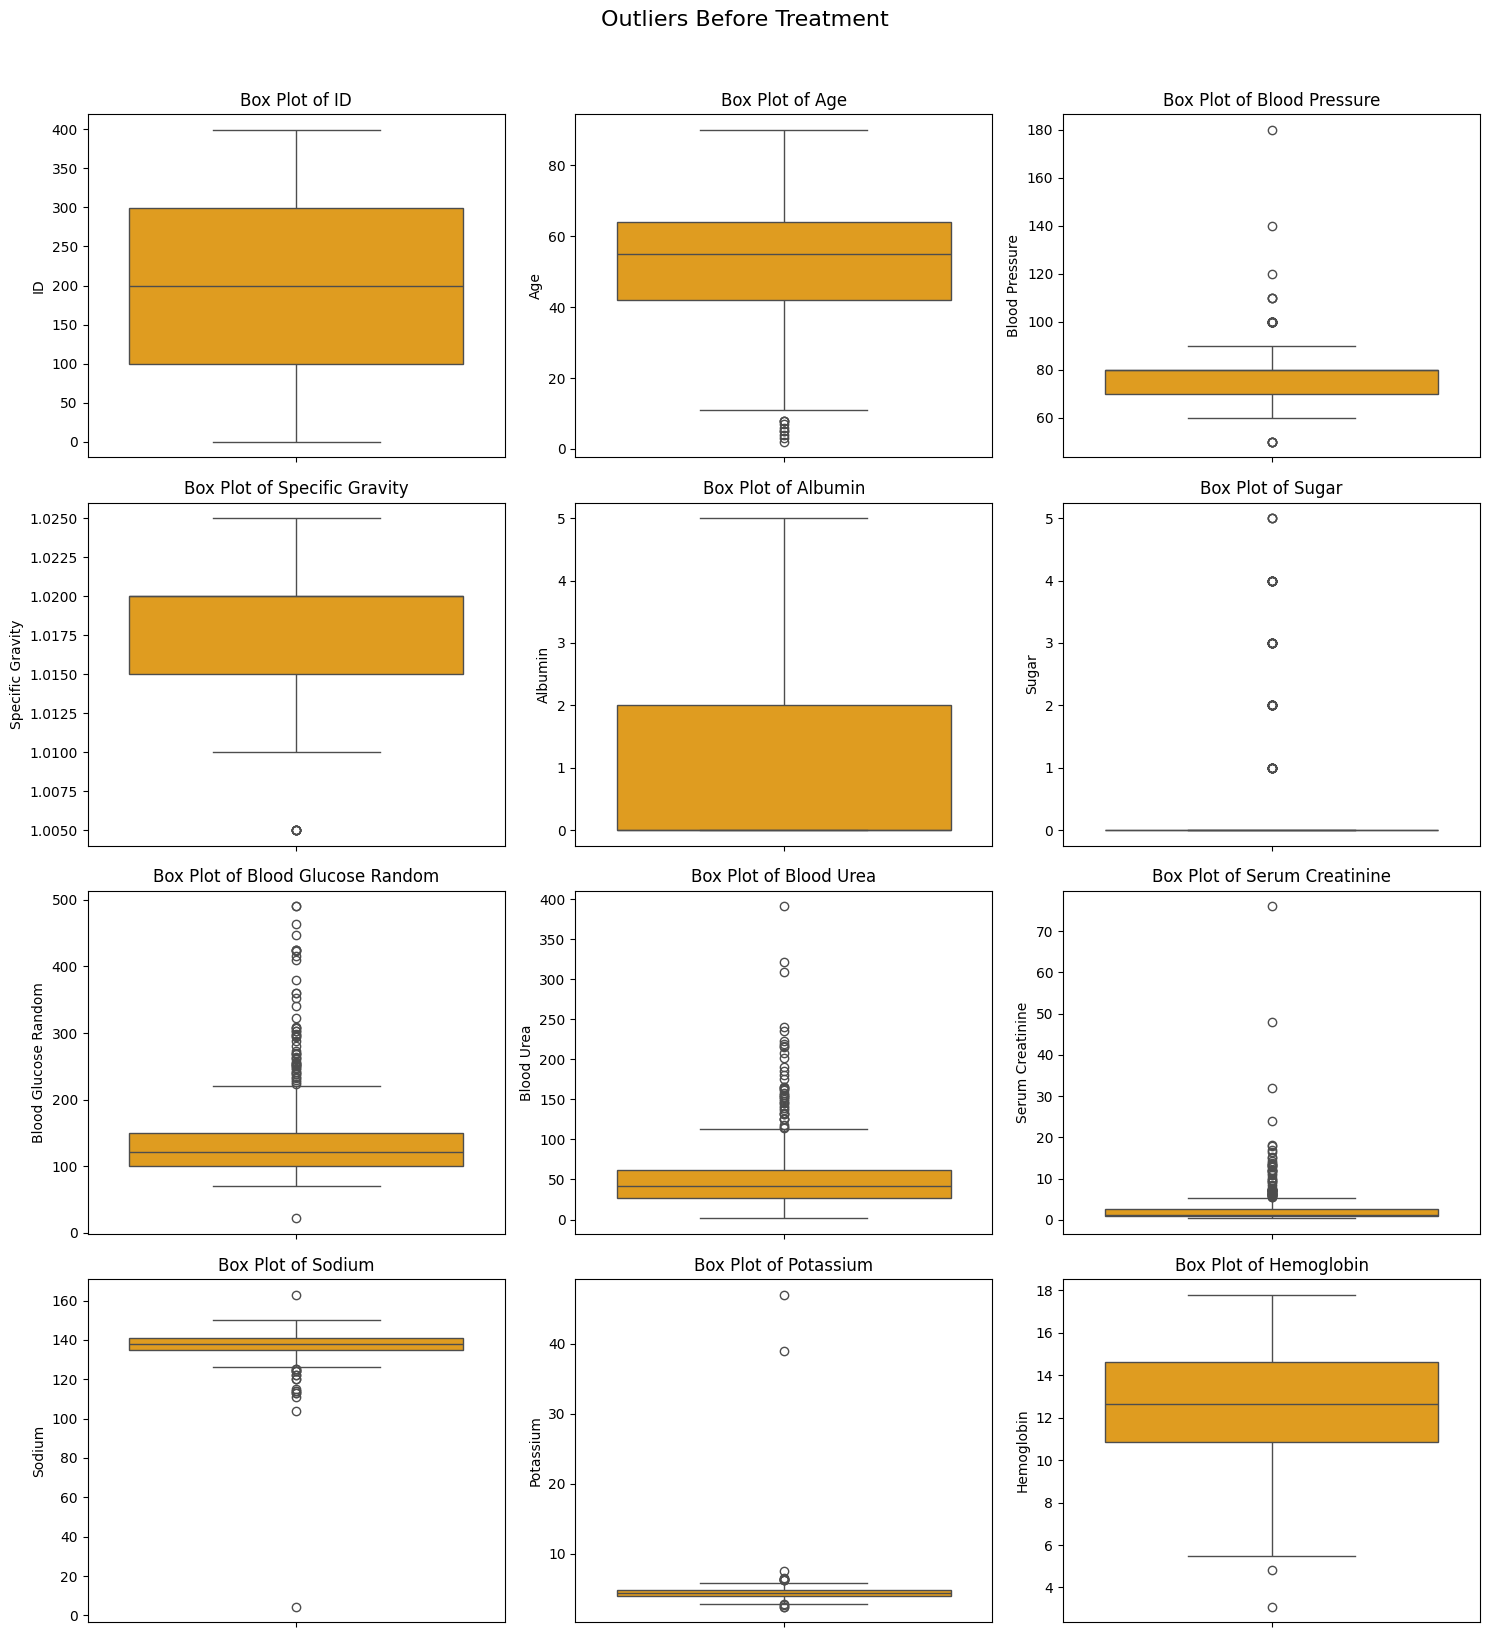

Treating outliers...
ID: Lower bound = -199.5, Upper bound = 598.5
Age: Lower bound = 9.0, Upper bound = 97.0
Blood Pressure: Lower bound = 55.0, Upper bound = 95.0
Specific Gravity: Lower bound = 1.0074999999999998, Upper bound = 1.0275000000000003
Albumin: Lower bound = -3.0, Upper bound = 5.0
Sugar: Lower bound = 0.0, Upper bound = 0.0
Blood Glucose Random: Lower bound = 27.5, Upper bound = 223.5
Blood Urea: Lower bound = -25.125, Upper bound = 113.875
Serum Creatinine: Lower bound = -1.8375000000000004, Upper bound = 5.4625
Sodium: Lower bound = 126.0, Upper bound = 150.0
Potassium: Lower bound = 2.8000000000000003, Upper bound = 6.0
Hemoglobin: Lower bound = 5.25, Upper bound = 20.25
Plotting outliers after treatment...


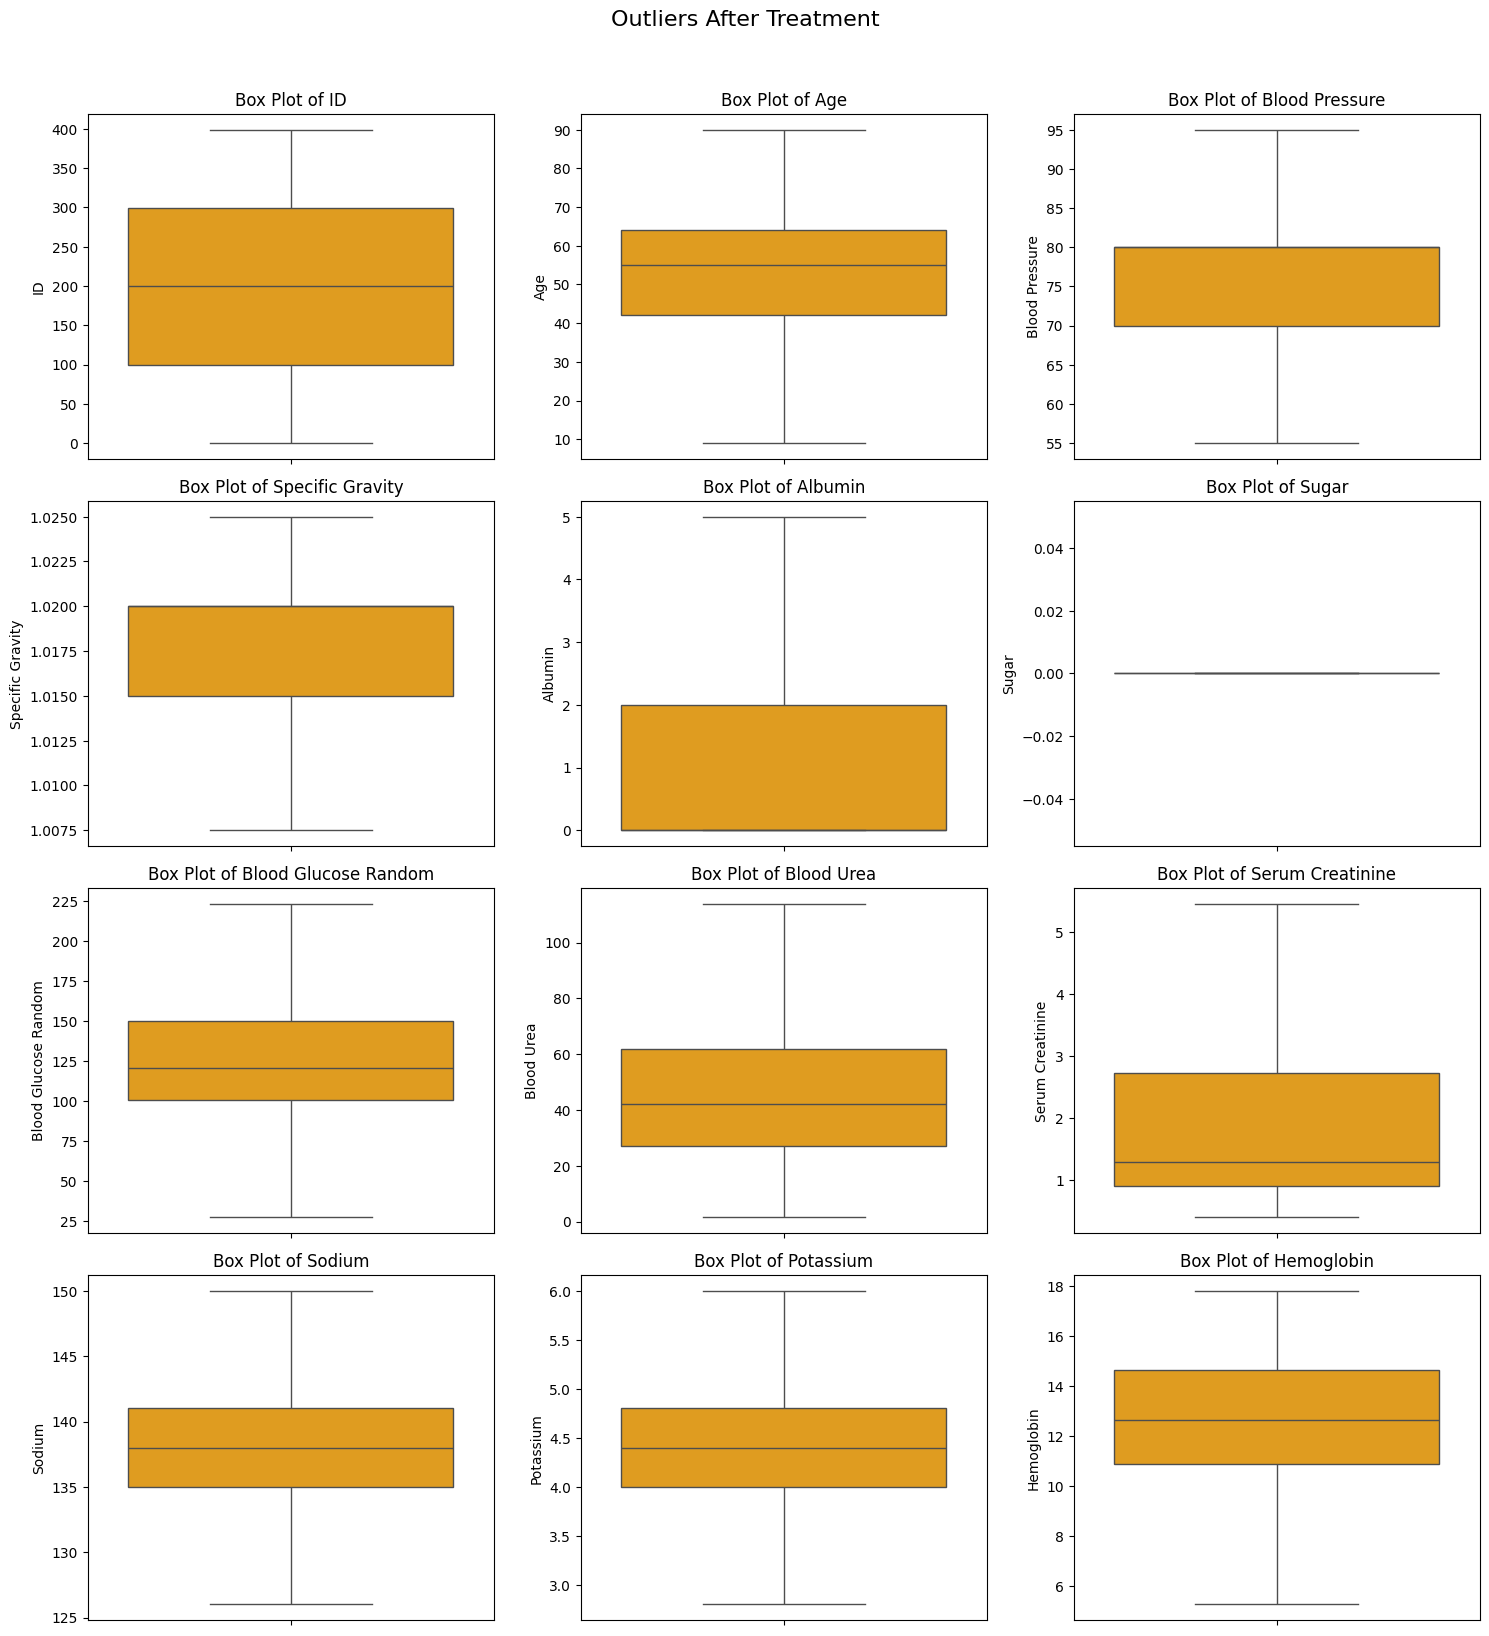


Data after encoding and scaling:
         ID       Age  Blood Pressure  Specific Gravity   Albumin  Sugar  \
0 -1.727726 -0.217955        0.381013          0.420662  0.076249    0.0   
1 -1.719066 -2.548388       -1.900504          0.420662  2.363728    0.0   
2 -1.710406  0.618610        0.381013         -1.454156  0.838742    0.0   
3 -1.701745 -0.217955       -0.531594         -1.922860  2.363728    0.0   
4 -1.693085 -0.038691        0.381013         -1.454156  0.838742    0.0   

   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  ...  \
0                1         1                0         0  ...   
1                1         1                0         0  ...   
2                1         1                0         0  ...   
3                1         0                1         0  ...   
4                1         1                0         0  ...   

   Packed Cell Volume  White Blood Cell Count  Red Blood Cell Count  \
0                  31                      71        

In [5]:
# Dataset is loaded into CKD_data
processed_data = preprocess_data(CKD_data)

## Exploratory Data Analysis (EDA)

Plotting numeric feature distributions...


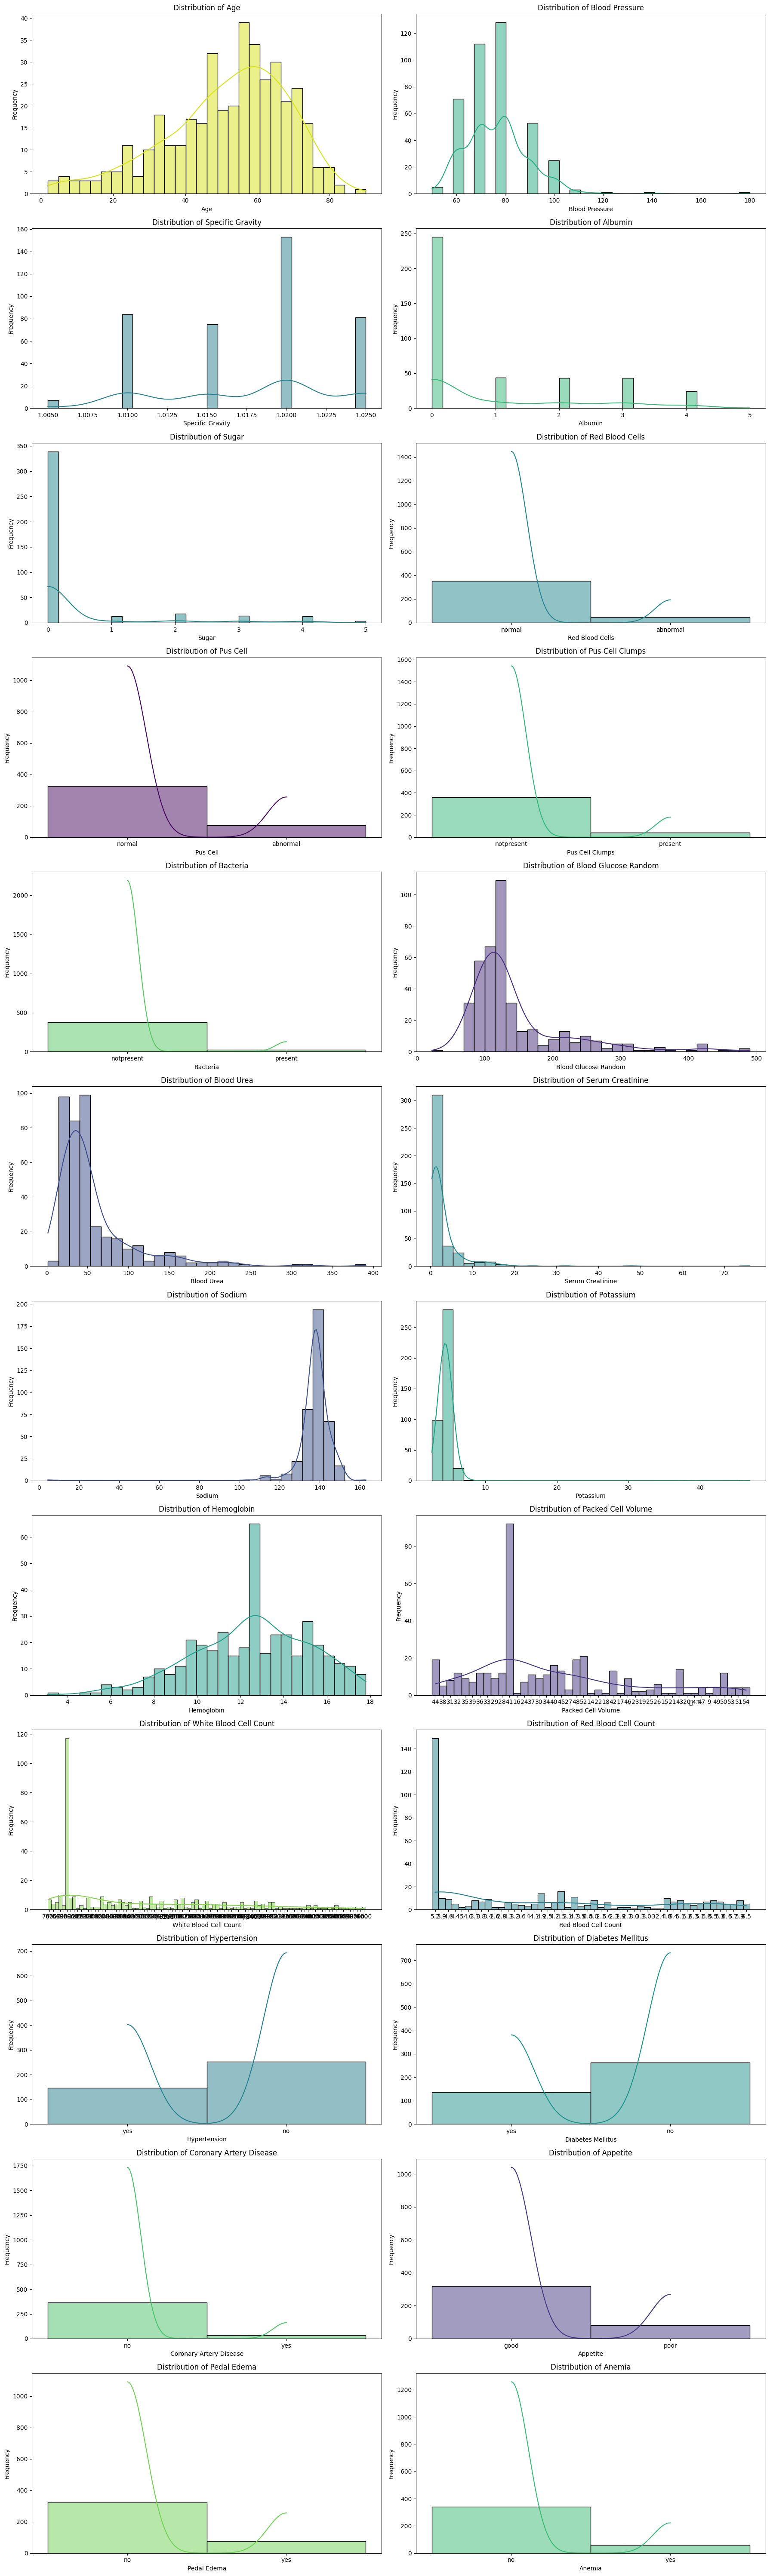

Plotting categorical feature counts...


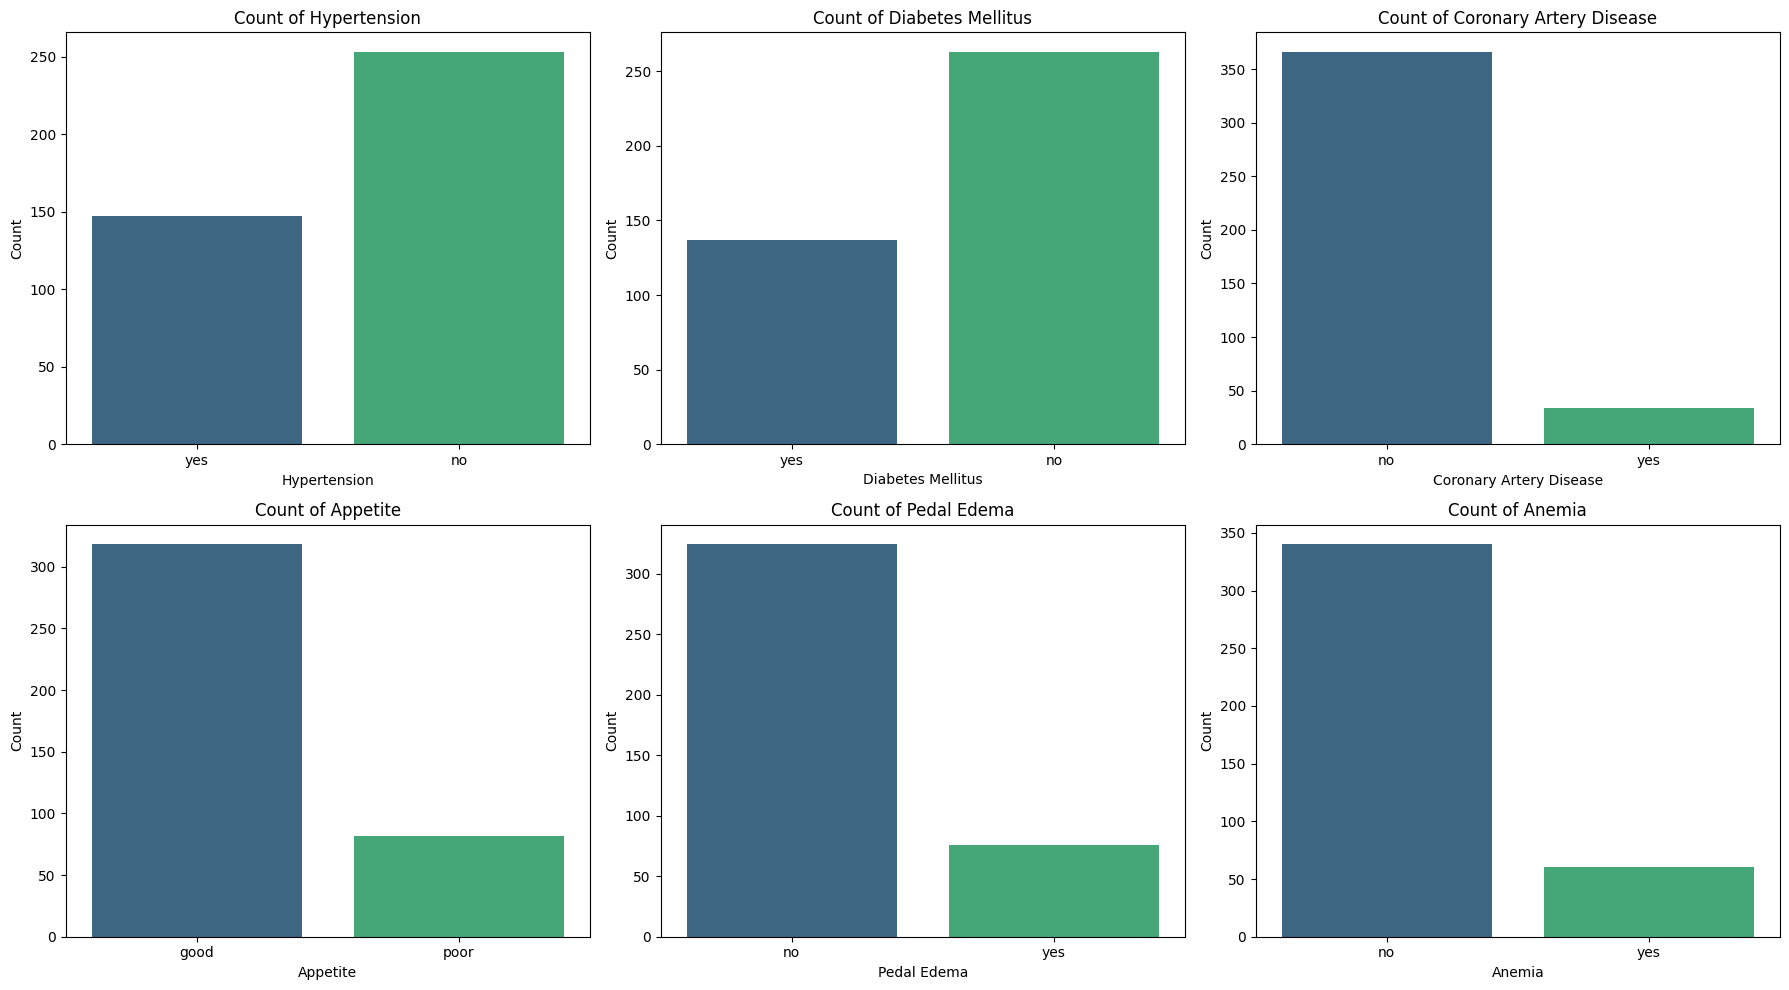

Plotting correlation heatmap...


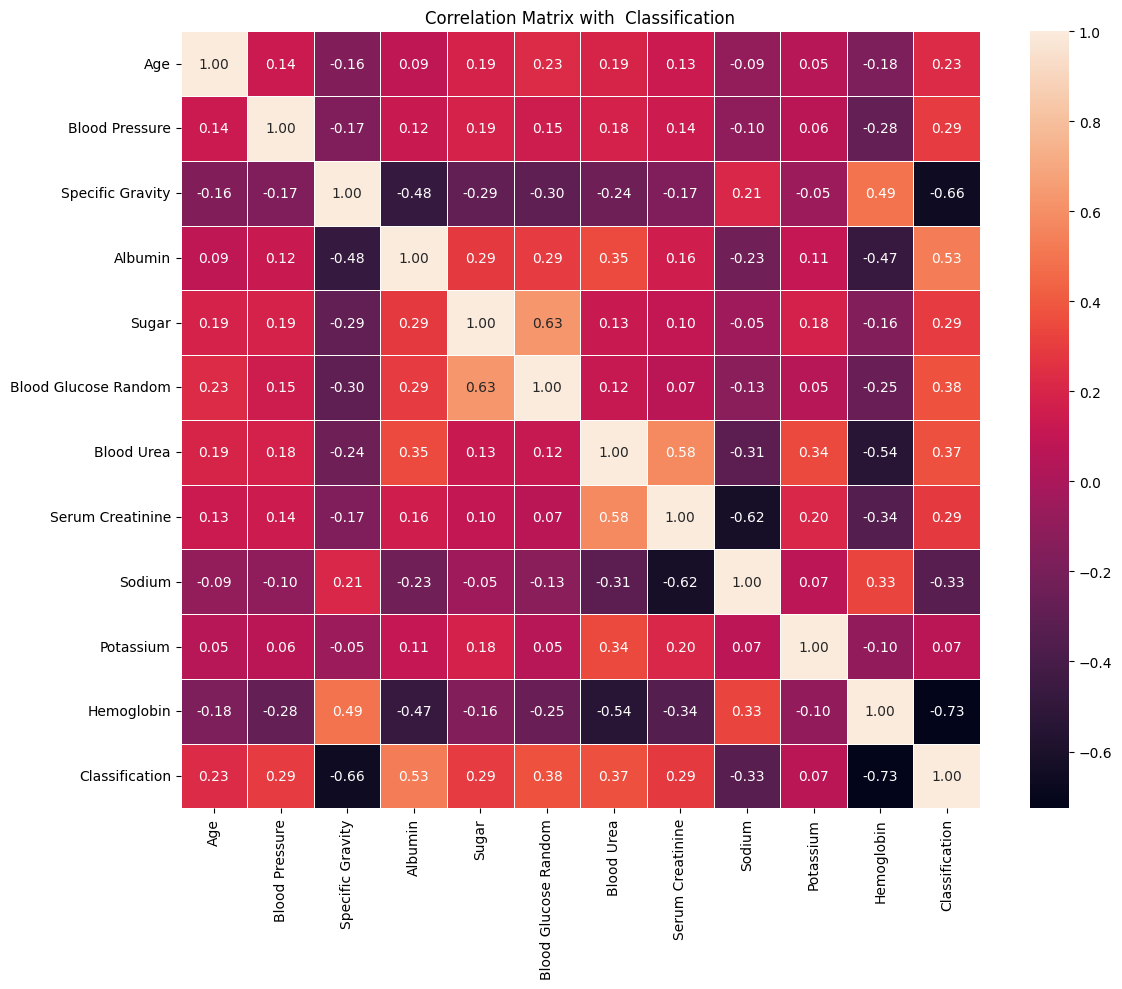

In [6]:

# Exploratory Data Analysis (EDA)
def plot_distributions(data, numeric_cols):
    """
    Plot distributions of numeric features.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric column names.
    """
    num_plots = len(numeric_cols)
    rows = (num_plots // 2) + (num_plots % 2 > 0)
    fig, axes = plt.subplots(rows, 2, figsize=(18, rows * 5))
    axes = axes.flatten()

    # List of random colors for each plot
    colors = [plt.cm.viridis(random.uniform(0, 1)) for _ in range(num_plots)]

    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], kde=True, bins=30, color=colors[i], ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_categorical_counts(data, categorical_cols):
    """
    Plot count plots for categorical variables.

    Parameters:
    data (pd.DataFrame): The dataset.
    categorical_cols (list): List of categorical column names.
    """
    num_plots = len(categorical_cols)
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=data[col], palette="viridis", ax=axes[i])
        axes[i].set_title(f"Count of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(data):
    """
    Plot a correlation heatmap for the dataset including the 'Classification' column.

    Parameters:
    data (pd.DataFrame): The dataset.
    """
    # Encode 'Classification' if not numeric
    if data['Classification'].dtype not in ['float64', 'int64']:
        data['Classification'] = data['Classification'].map({'ckd': 1, 'notckd': 0})

    # Exclude the 'ID' column and select only numeric columns
    numeric_data = data.drop(columns=['ID']).select_dtypes(include=['float64', 'int64'])

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix with  Classification")
    plt.tight_layout()
    plt.show()


# Performing EDA
numeric_cols = [col for col in CKD_data.columns if col not in ['ID','Classification']]
categorical_cols = ['Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                    'Appetite', 'Pedal Edema', 'Anemia']

print("Plotting numeric feature distributions...")
plot_distributions(CKD_data, numeric_cols)

print("Plotting categorical feature counts...")
plot_categorical_counts(CKD_data, categorical_cols)

print("Plotting correlation heatmap...")
plot_correlation_heatmap(CKD_data)


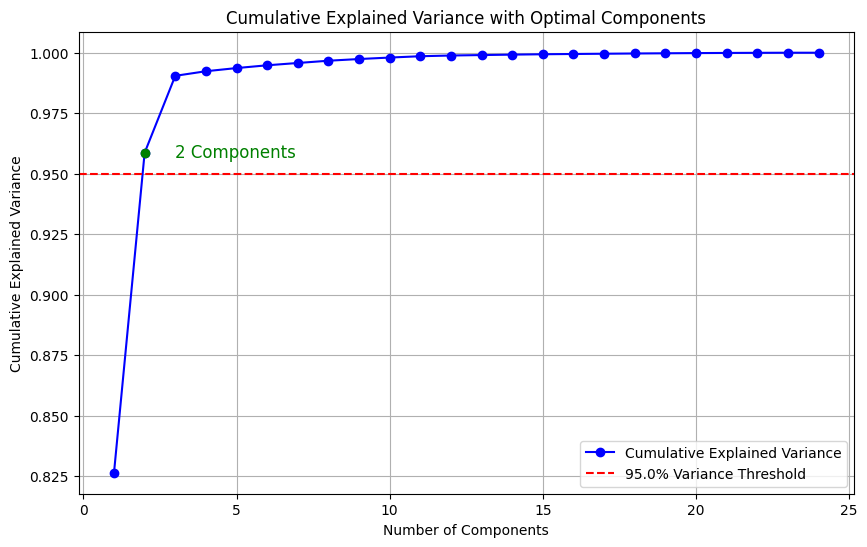

Top contributing features to Component 1:
White Blood Cell Count    0.994837
Red Blood Cell Count      0.097146
Packed Cell Volume        0.028993
Pus Cell                  0.001408
Specific Gravity          0.001337
dtype: float64


Top contributing features to Component 2:
Red Blood Cell Count    0.750634
Packed Cell Volume      0.638660
Hemoglobin              0.070188
Specific Gravity        0.043051
Sodium                  0.040602
dtype: float64


Top contributing features to Component 3:
Packed Cell Volume        0.754509
Hemoglobin                0.049465
White Blood Cell Count    0.041337
Specific Gravity          0.026946
Sodium                    0.024113
dtype: float64


Top contributing features to Component 4:
Blood Glucose Random    0.386466
Serum Creatinine        0.382816
Albumin                 0.368728
Blood Urea              0.363943
Age                     0.270995
dtype: float64


Top contributing features to Component 5:
Potassium           0.646558
Specific Grav

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Assuming the preprocessing function is already implemented as preprocess_data
def apply_pca_optimal_components1(X, variance_threshold=0.95):
    """
    Apply PCA and generate plots showing the number of components to retain based on cumulative explained variance.

    Parameters:
    X (pd.DataFrame): The features to perform PCA on.
    variance_threshold (float): The cumulative variance threshold to decide the number of components to retain.

    Returns:
    X_pca (np.array): The transformed data with reduced dimensions.
    pca (PCA object): The fitted PCA model.
    optimal_num_components (int): The optimal number of components based on the threshold.
    """
    # Apply PCA to reduce dimensions and obtain explained variance
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot Cumulative Explained Variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', label='Cumulative Explained Variance')
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100}% Variance Threshold')

    # Highlight the optimal number of components
    optimal_num_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    plt.scatter(optimal_num_components, cumulative_variance[optimal_num_components - 1], color='green', zorder=5)
    plt.text(optimal_num_components + 1, cumulative_variance[optimal_num_components - 1],
             f'{optimal_num_components} Components', color='green', fontsize=12, verticalalignment='center')

    # Add labels and title
    plt.title('Cumulative Explained Variance with Optimal Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 5: Get the names of the original features (use columns of the dataset)
    features = X.columns

    # Step 6: Loop through all components and show the contribution of each feature
    for i, component in enumerate(pca.components_):
        component_contribution = pd.Series(component, index=features).sort_values(ascending=False)
        print(f"Top contributing features to Component {i+1}:")
        print(component_contribution.head())  # Display top 5 contributing features for each component
        print("\n")


    # Display the number of components and the explained variance
    print(f"Optimal number of components to retain {variance_threshold*100}% variance: {optimal_num_components}")
    print(f"Cumulative explained variance: {cumulative_variance[-1]:.4f}")

    return X_pca, pca, optimal_num_components


X = processed_data.drop(columns=['Classification', 'ID'])

# Apply PCA to the preprocessed data
X_pca, pca_model,optimal_num_components = apply_pca_optimal_components1(X, variance_threshold=0.95)



Variance Inflation Factor (VIF):
                 Feature           VIF
0                  const  53937.041163
1                    Age      1.107525
2         Blood Pressure      1.121064
3       Specific Gravity      1.545864
4                Albumin      1.567571
5                  Sugar      1.818931
6   Blood Glucose Random      1.797435
7             Blood Urea      2.181824
8       Serum Creatinine      2.397746
9                 Sodium      1.887444
10             Potassium      1.241974
11            Hemoglobin      2.000912


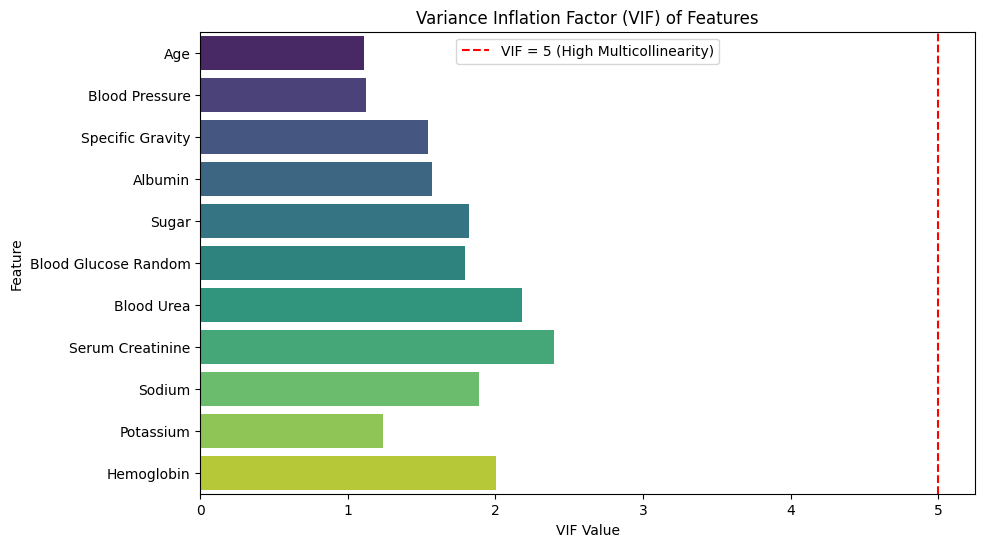

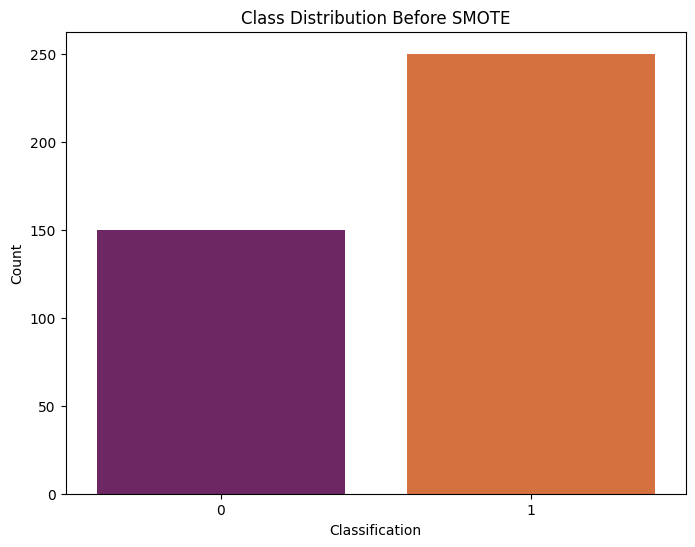

Class Imbalance:
Classification
1    250
0    150
Name: count, dtype: int64


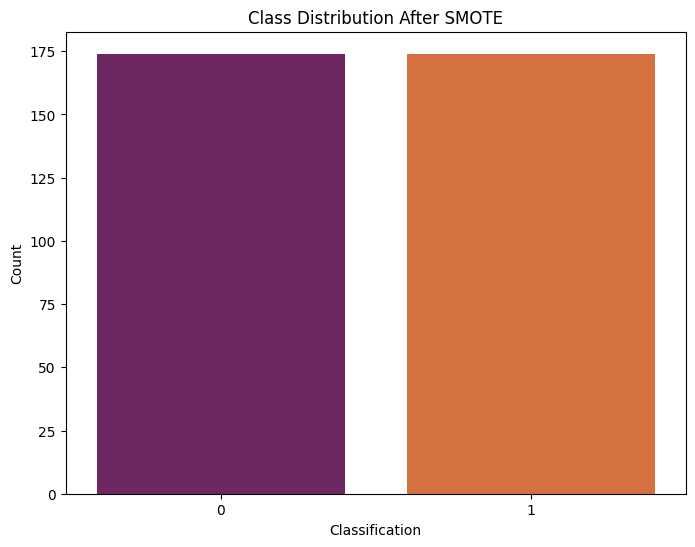

Class Distribution After SMOTE:
Classification
0    174
1    174
Name: count, dtype: int64


In [12]:

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for the features.

    Parameters:
    X (pd.DataFrame): Dataset for which to calculate VIF.

    Returns:
    pd.DataFrame: DataFrame containing features and their VIF values.
    """
    # Ensure input only contains numerical data
    X_numeric = X.select_dtypes(include=['float64', 'int64'])
    X_numeric = add_constant(X_numeric)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    print("Variance Inflation Factor (VIF):")
    print(vif_data)

    # Exclude "age" only from the plot, but keep it in calculations
    vif_plot_data = vif_data[vif_data["Feature"] != "const"]

    # Plot VIF values as a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(y="Feature", x="VIF", data=vif_plot_data, palette="viridis")
    plt.axvline(x=5, color='red', linestyle='--', label="VIF = 5 (High Multicollinearity)")
    plt.xlabel("VIF Value")
    plt.ylabel("Feature")
    plt.title("Variance Inflation Factor (VIF) of Features")
    plt.legend()
    plt.show()
    return vif_data



def apply_smote(X, y):
    """
    Apply SMOTE to handle class imbalance.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.

    Returns:
    Tuple: Resampled features and target variable.
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# After preprocessing numerical and categorical features

X_for_vif = CKD_data.drop(columns=['Classification', 'ID'])

# Calculate VIF (only numeric columns)
vif_data = calculate_vif(X_for_vif)



# Check for class imbalance in the target variable
# Class distribution before SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(data=CKD_data, x='Classification', palette='inferno')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

# Count of each class
class_counts = CKD_data['Classification'].value_counts()
print("Class Imbalance:")
print(class_counts)

# Step 3: Data Splitting and Balancing

# Ensure all features in X are numeric before SMOTE
X_numeric = X_for_vif.select_dtypes(include=['float64', 'int64'])
y = processed_data['Classification']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training dataset
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

# Class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled, palette='inferno')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

print(f"Class Distribution After SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")


In [13]:

# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

def train_and_evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    Train and evaluate multiple models.

    Parameters:
    X_train, X_test, y_train, y_test: Dataset splits
    models (dict): Dictionary of model names and initialized models

    Returns:
    None: Prints the evaluation results for each model.
    """
    for model_name, model in models.items():
        print(f"\nTraining and Evaluating: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

# Call the function to train and evaluate the models
train_and_evaluate_models(X_train_resampled, X_test, y_train_resampled, y_test, models)



Training and Evaluating: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        76
           1       0.96      0.98      0.97        44

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120

Confusion Matrix:
[[74  2]
 [ 1 43]]

Training and Evaluating: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        76
           1       0.96      1.00      0.98        44

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120

Confusion Matrix:
[[74  2]
 [ 0 44]]

Training and Evaluating: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.0

Evaluating: Logistic Regression


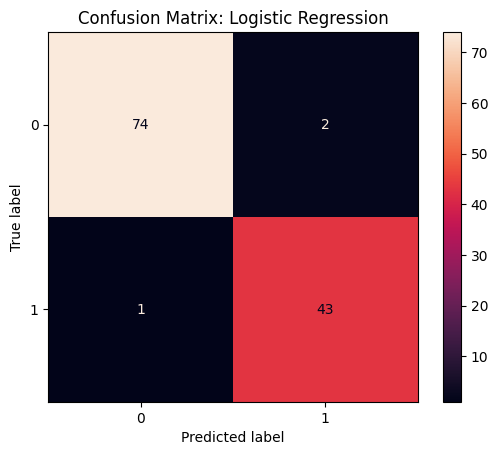

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        76
           1       0.96      0.98      0.97        44

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120

Evaluating: Decision Tree


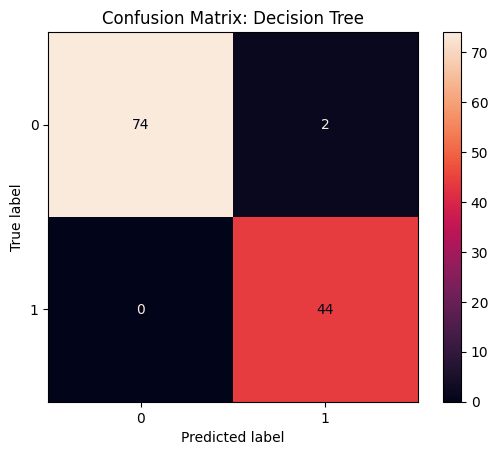

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        76
           1       0.96      1.00      0.98        44

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120

Evaluating: Random Forest


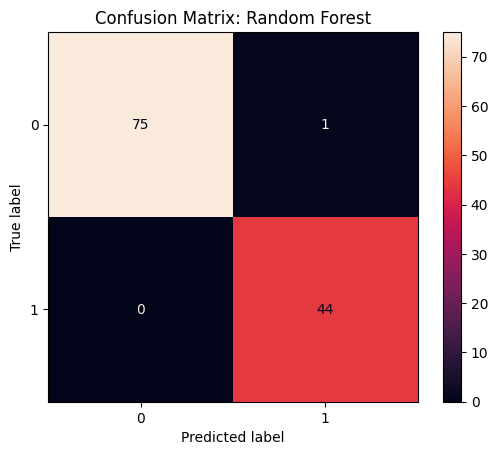

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Evaluating: SVM


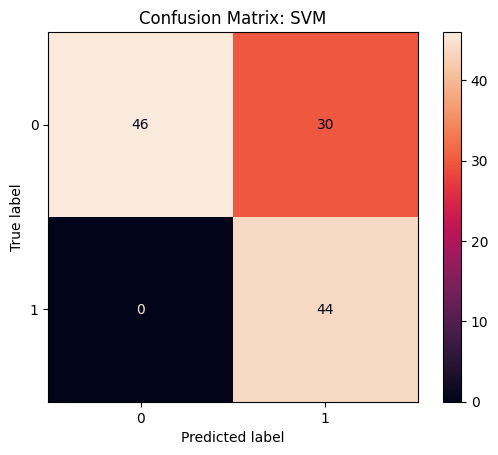

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.61      0.75        76
           1       0.59      1.00      0.75        44

    accuracy                           0.75       120
   macro avg       0.80      0.80      0.75       120
weighted avg       0.85      0.75      0.75       120

Evaluating: XGBoost


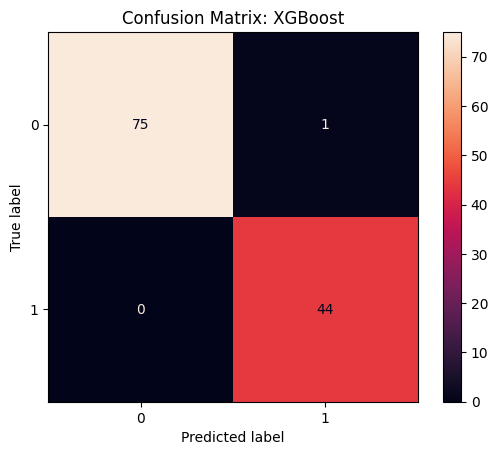

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



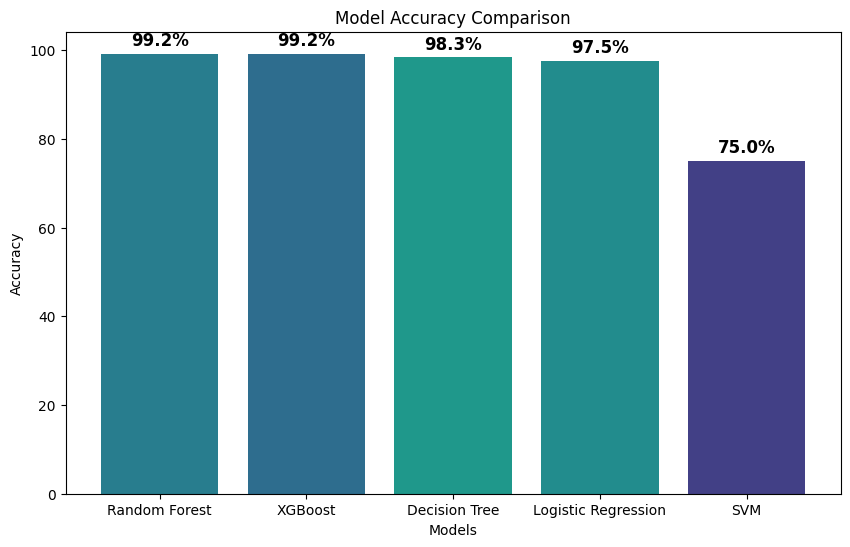

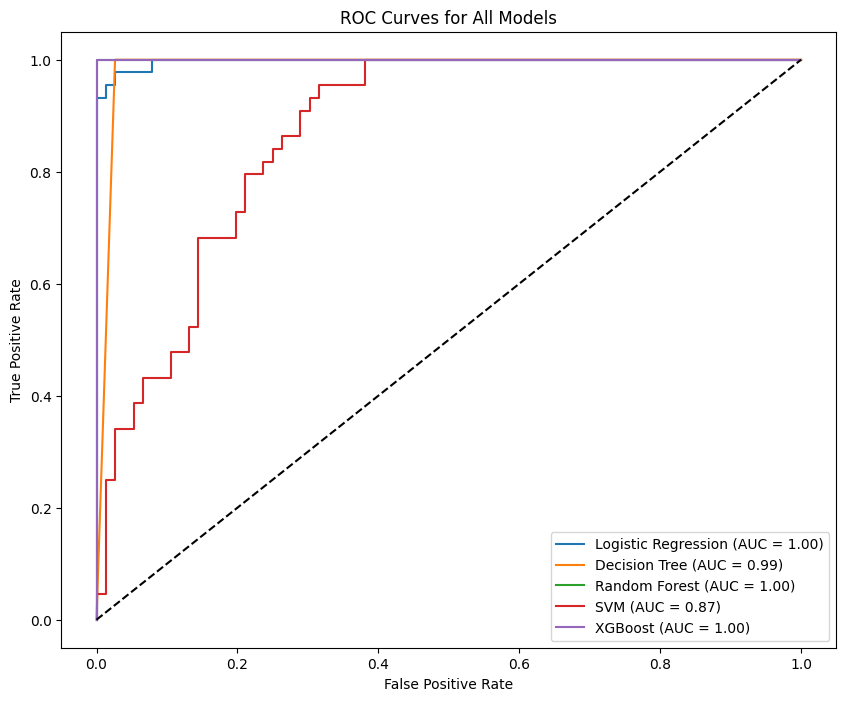

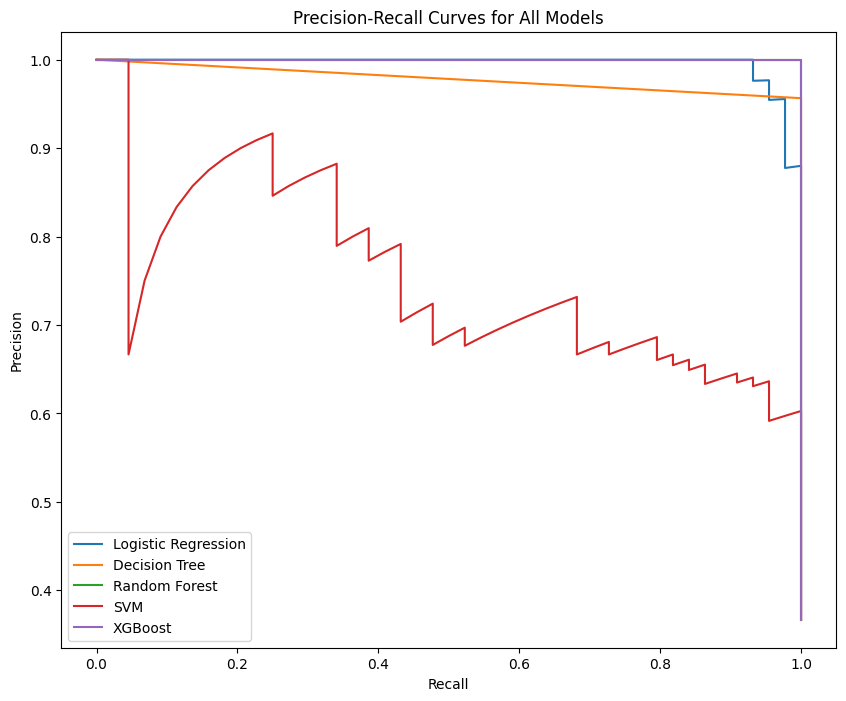

In [14]:

def evaluate_and_plot_results(X_train, X_test, y_train, y_test, models):
    """
    Train models, calculate performance metrics, and plot evaluation results.

    Parameters:
    X_train, X_test, y_train, y_test: Dataset splits
    models (dict): Dictionary of model names and initialized models

    Returns:
    None: Plots accuracy, confusion matrix, ROC curves, and precision-recall curves.
    """
    model_results = {}
    roc_curves = {}
    precision_recall_curves = {}
    accuracies = []

    # Train and evaluate models
    for model_name, model in models.items():
        print(f"Evaluating: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append((model_name, accuracy))

        # Store confusion matrix
        cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="rocket")
        cm_display.ax_.set_title(f"Confusion Matrix: {model_name}")
        plt.show()

        # Store ROC curve data
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_curves[model_name] = (fpr, tpr, roc_auc)

        # Store Precision-Recall curve data
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        precision_recall_curves[model_name] = (precision, recall)

        # Print classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

    # Plot accuracies
    plt.figure(figsize=(10, 6))

    # Sort models by accuracy (descending order)
    accuracies.sort(key=lambda x: x[1], reverse=True)
    model_names, acc_values = zip(*accuracies)

    # Convert accuracy values to percentage
    acc_values = [x * 100 for x in acc_values]

    # Generate random colors for each bar
    colors = [plt.cm.viridis(random.uniform(0, 1)) for _ in model_names]

    # Vertical bar plot with different colors
    bars = plt.bar(model_names, acc_values, color=colors)

    plt.xlabel("Models")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)


    # Display accuracy values on top of each bar
    for bar, acc in zip(bars, acc_values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{acc:.1f}%",
                 ha="center", va="bottom", fontsize=12, fontweight="bold")


    plt.show()

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for All Models")
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for model_name, (precision, recall) in precision_recall_curves.items():
        plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for All Models")
    plt.legend(loc="lower left")
    plt.show()


# Call the function
evaluate_and_plot_results(X_train_resampled, X_test, y_train_resampled, y_test, models)


In [15]:
def hyperparameter_tuning(X_train, y_train):
    """
    Perform hyperparameter tuning for Logistic Regression, Decision Tree, Random Forest, and SVM using GridSearchCV.

    Parameters:
    X_train, y_train: Training data and target variable.

    Returns:
    best_models (dict): Dictionary with model names and best models after hyperparameter tuning.
    """
    # Define parameter grids for each model
    param_grids = {
        "Logistic Regression": {
            "C": [0.01, 0.1, 1, 10, 100],
            "solver": ["liblinear", "saga"],
            "penalty": ["l1", "l2"]
        },
        "Decision Tree": {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        },
        "Random Forest": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "SVM": {
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto"],
            "kernel": ["linear", "rbf"]
        },
        "XGBoost": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0]
        }
    }

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=5000,solver="saga"),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "XGBoost": xgb.XGBClassifier( eval_metric='mlogloss', random_state=42)
    }

    best_models = {}

    # Perform GridSearchCV for each model
    for model_name, model in models.items():
        print(f"Tuning hyperparameters for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            scoring="accuracy",
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_:.4f}")

    return best_models

# Perform hyperparameter tuning
best_models = hyperparameter_tuning(X_train_resampled, y_train_resampled)

# Print the best models
print("\nBest Models After Hyperparameter Tuning:")
for model_name, model in best_models.items():
    print(f"{model_name}: {model}")


Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9800
Tuning hyperparameters for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score for Decision Tree: 0.9684
Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 0.9829
Tuning hyperparameters for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best score for SVM: 0.9800
Tuning hyperparameters for XGB

In [16]:
def compute_cv_scores(models, X, y, cv=15):
    """
    Compute cross-validation scores for each model using different scoring metrics.
    """
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']  # List of metrics to evaluate
    cv_results = {}

    # Compute CV scores for each model and each scoring metric
    print("\nCross-Validation Scores After Hyperparameter Tuning:")
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        scores = {}
        for score in scoring_metrics:
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring=score)
            scores[score] = cv_scores
            print(f"{score.capitalize()} Mean CV Score: {cv_scores.mean():.6f}")
            print(f"{score.capitalize()} Standard Deviation: {cv_scores.std():.6f}")
            print(f"{score.capitalize()} All CV Scores: {cv_scores}")
        cv_results[model_name] = scores

    return cv_results  # Return the results

# Call the function to compute CV scores
cv_results = compute_cv_scores(best_models, X_train_resampled, y_train_resampled)



Cross-Validation Scores After Hyperparameter Tuning:

Evaluating Logistic Regression...
Accuracy Mean CV Score: 0.982609
Accuracy Standard Deviation: 0.021300
Accuracy All CV Scores: [1.         1.         1.         1.         0.95652174 0.95652174
 1.         0.95652174 0.95652174 0.95652174 1.         1.
 1.         1.         0.95652174]
Precision Mean CV Score: 0.978205
Precision Standard Deviation: 0.036171
Precision All CV Scores: [1.         1.         1.         1.         0.91666667 0.91666667
 1.         1.         0.91666667 1.         1.         1.
 1.         1.         0.92307692]
Recall Mean CV Score: 0.988384
Recall Standard Deviation: 0.029648
Recall All CV Scores: [1.         1.         1.         1.         1.         1.
 1.         0.90909091 1.         0.91666667 1.         1.
 1.         1.         1.        ]
F1 Mean CV Score: 0.982565
F1 Standard Deviation: 0.021399
F1 All CV Scores: [1.         1.         1.         1.         0.95652174 0.95652174
 1.       

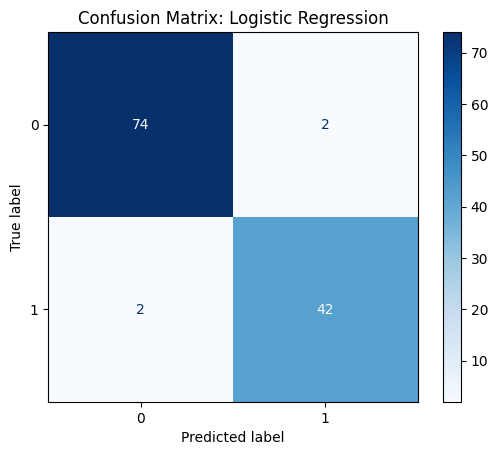

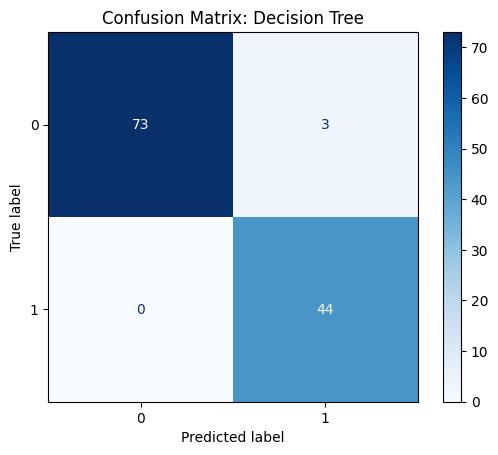

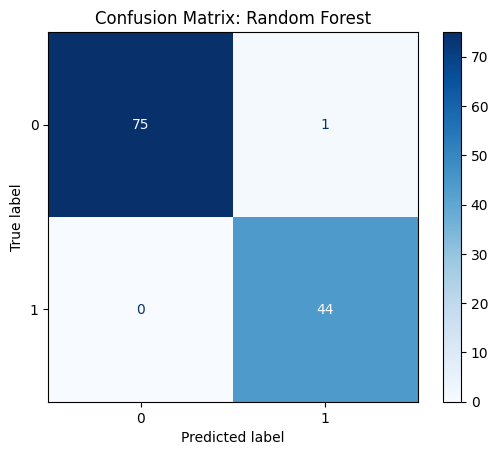

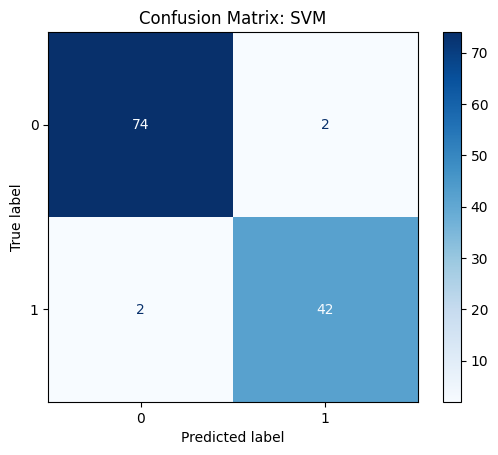

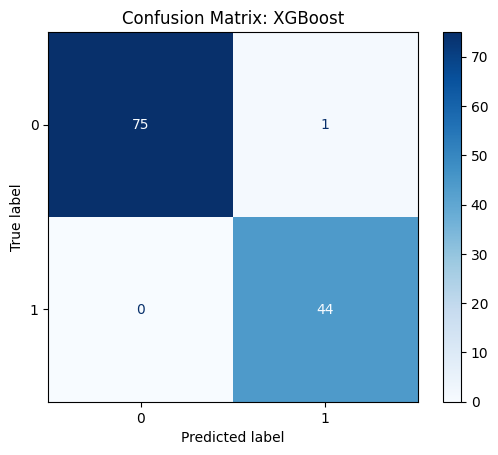

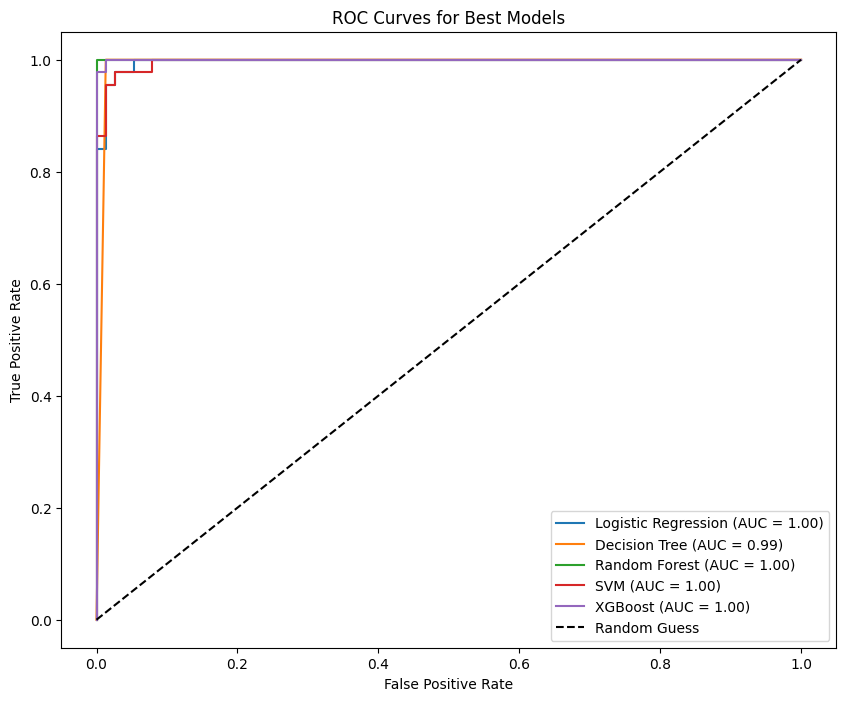

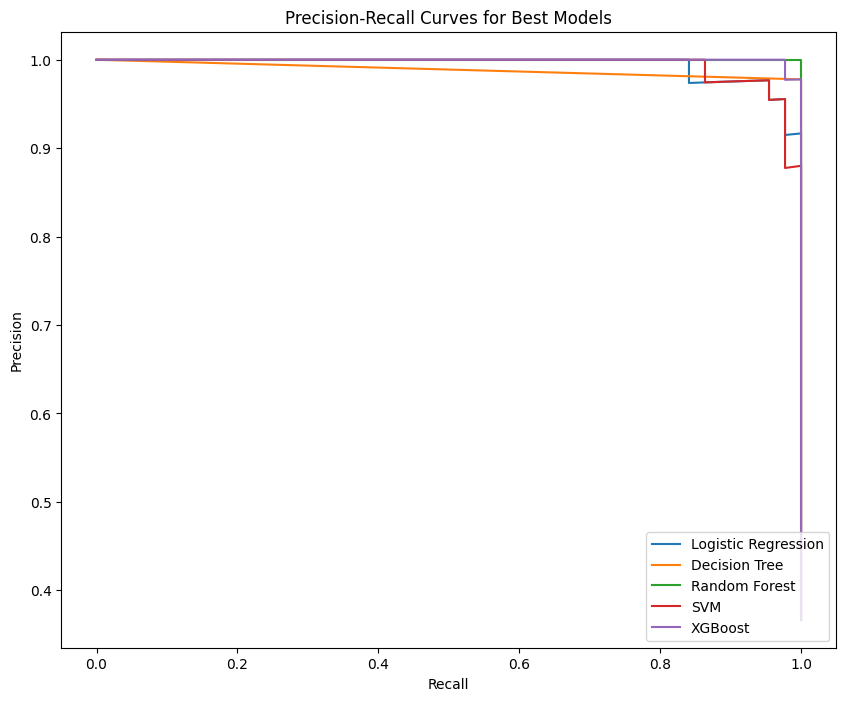

In [17]:

# Function to plot confusion matrices for the best models
def plot_confusion_matrices(best_models, X_test, y_test):
    """
    Plot confusion matrices for the best models.

    Parameters:
    best_models (dict): Dictionary of best models after hyperparameter tuning.
    X_test, y_test: Test dataset and target.
    """
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix: {model_name}")
        plt.show()

# Function to plot ROC and Precision-Recall curves
def plot_roc_and_precision_curves(best_models, X_test, y_test):
    """
    Plot ROC and Precision-Recall curves for the best models.

    Parameters:
    best_models (dict): Dictionary of best models after hyperparameter tuning.
    X_test, y_test: Test dataset and target.
    """
    # Initialize dictionaries for storing ROC and PR data
    roc_data = {}
    pr_data = {}

    # Generate data for each model
    for model_name, model in best_models.items():
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        roc_data[model_name] = (fpr, tpr, roc_auc)
        pr_data[model_name] = (precision, recall)

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, roc_auc) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Best Models")
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for model_name, (precision, recall) in pr_data.items():
        plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for Best Models")
    plt.legend(loc="lower right")
    plt.show()

# Call the plotting functions
plot_confusion_matrices(best_models, X_test, y_test)
plot_roc_and_precision_curves(best_models, X_test, y_test)



Evaluating Logistic Regression on the Test Set...

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        76
           1       0.95      0.95      0.95        44

    accuracy                           0.97       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.97      0.97      0.97       120


Confusion Matrix:
[[74  2]
 [ 2 42]]
Accuracy: 0.9667


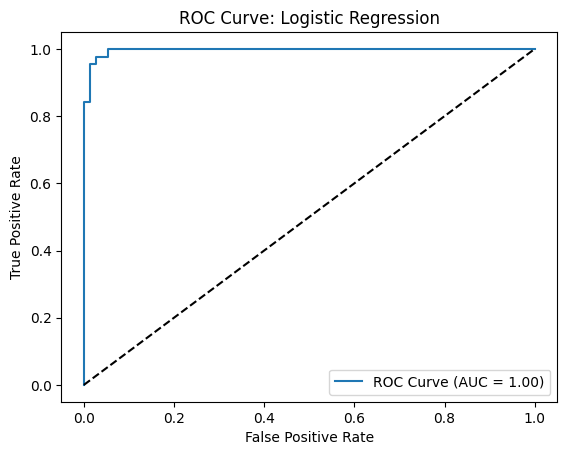

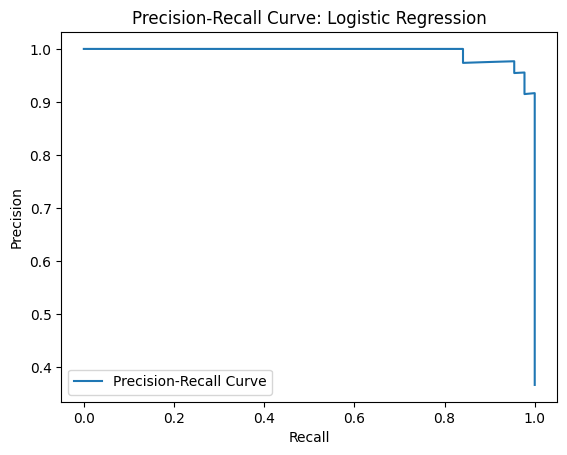


Evaluating Decision Tree on the Test Set...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        76
           1       0.94      1.00      0.97        44

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120


Confusion Matrix:
[[73  3]
 [ 0 44]]
Accuracy: 0.9750


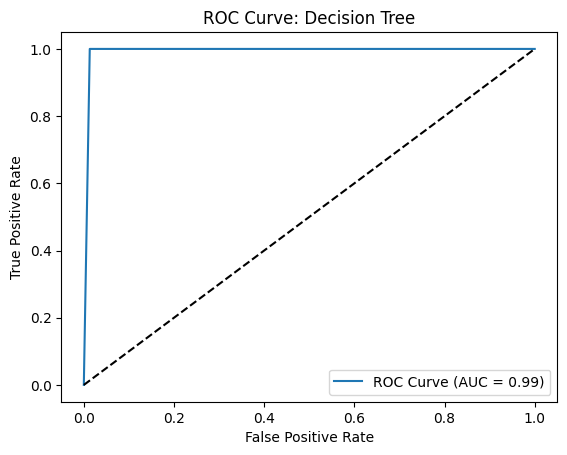

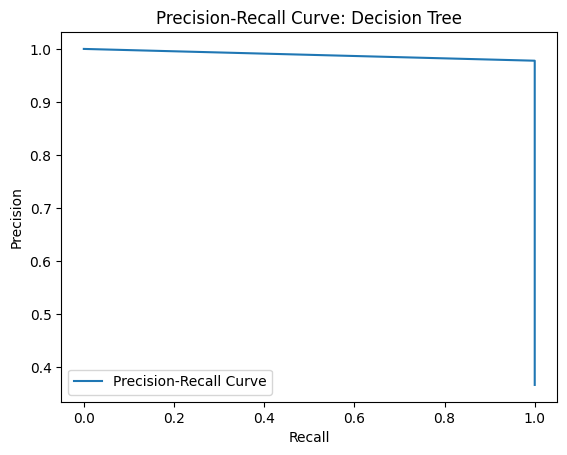


Evaluating Random Forest on the Test Set...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120


Confusion Matrix:
[[75  1]
 [ 0 44]]
Accuracy: 0.9917


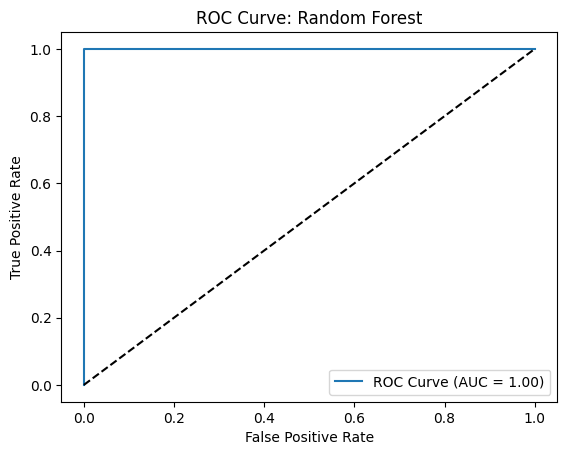

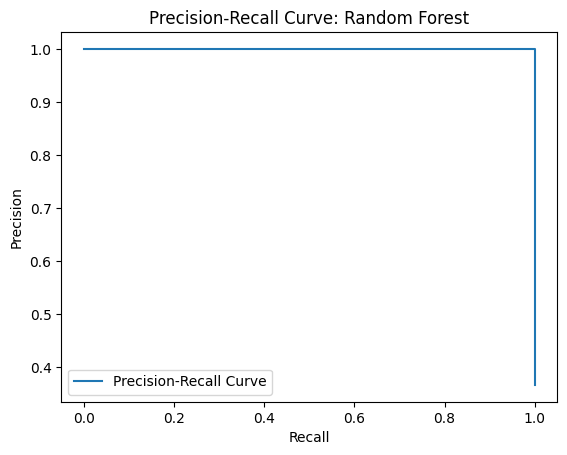


Evaluating SVM on the Test Set...

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        76
           1       0.95      0.95      0.95        44

    accuracy                           0.97       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.97      0.97      0.97       120


Confusion Matrix:
[[74  2]
 [ 2 42]]
Accuracy: 0.9667


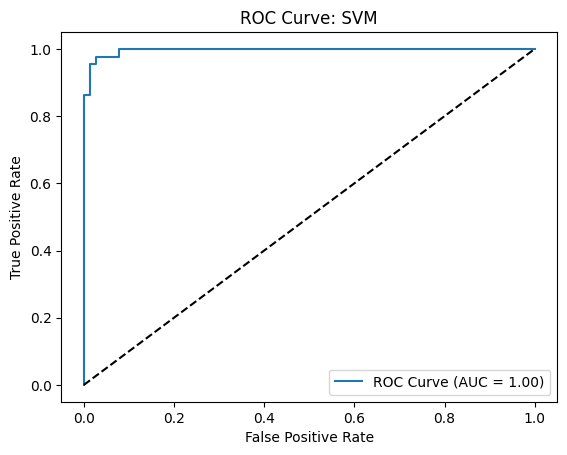

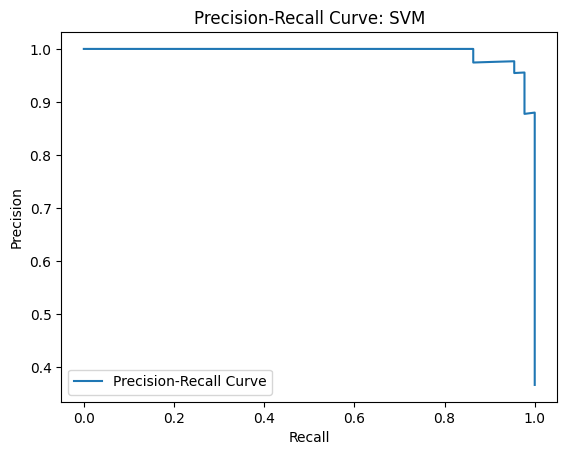


Evaluating XGBoost on the Test Set...

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.98      1.00      0.99        44

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120


Confusion Matrix:
[[75  1]
 [ 0 44]]
Accuracy: 0.9917


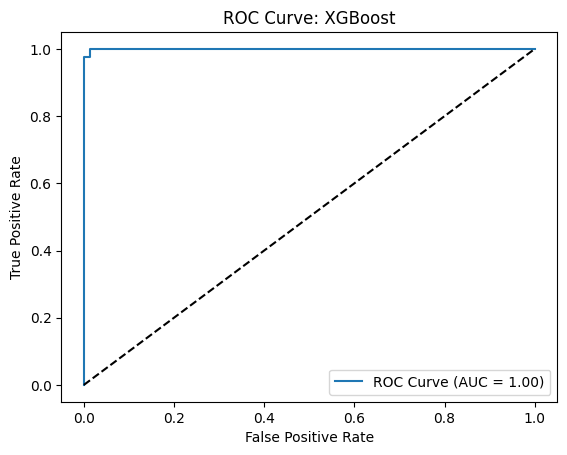

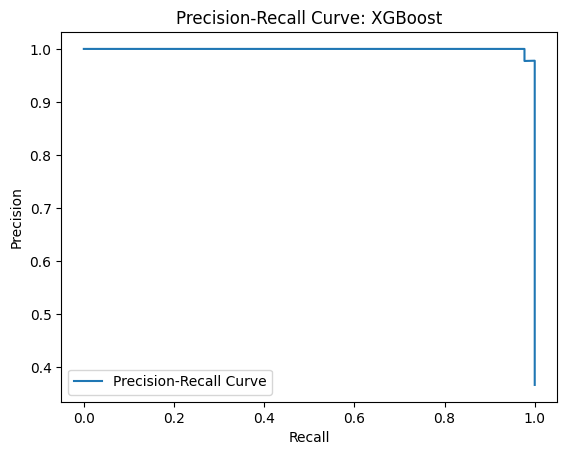

In [18]:

#Performance Evaluation on Unseen Data (Testing on Test Set)

def evaluate_on_test_set(best_models, X_test, y_test):
    """
    Evaluate the best-tuned models on the unseen test set.

    Parameters:
    best_models (dict): Dictionary containing trained best models.
    X_test (pd.DataFrame): Test features.
    y_test (pd.Series): Test target.

    Returns:
    None: Prints evaluation metrics and plots performance curves.
    """
    for model_name, model in best_models.items():
        print(f"\nEvaluating {model_name} on the Test Set...")

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        # Metrics
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # ROC Curve
        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.figure()
            plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f"ROC Curve: {model_name}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.show()

        # Precision-Recall Curve
        if y_pred_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            plt.figure()
            plt.plot(recall, precision, label=f"Precision-Recall Curve")
            plt.title(f"Precision-Recall Curve: {model_name}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.legend(loc="lower left")
            plt.show()

# Call the function to evaluate models on the test set
evaluate_on_test_set(best_models, X_test, y_test)


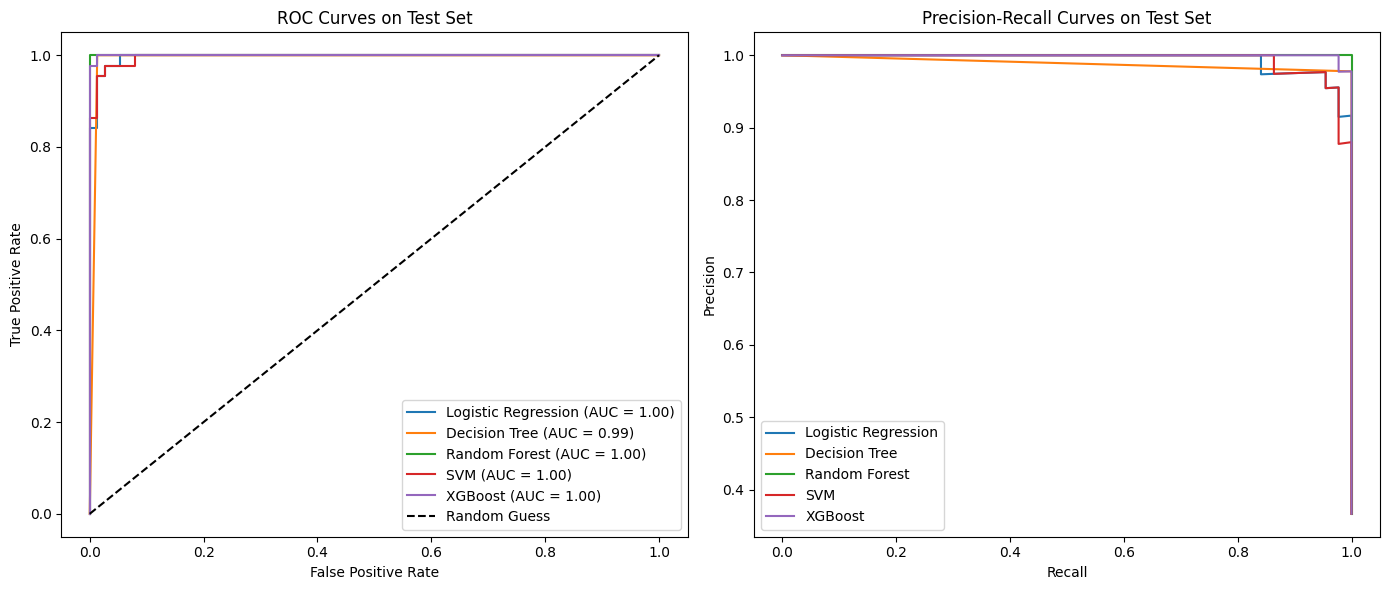

In [19]:
def plot_test_set_comparisons(best_models, X_test, y_test):
    """
    Plot ROC and Precision-Recall curves for all models on the test set.

    Parameters:
    best_models (dict): Dictionary of the best models after tuning.
    X_test (pd.DataFrame): Test feature set.
    y_test (pd.Series): Test target labels.
    """
    # Initialize plots
    plt.figure(figsize=(14, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for model_name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title("ROC Curves on Test Set")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for model_name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        if y_pred_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            plt.plot(recall, precision, label=model_name)
    plt.title("Precision-Recall Curves on Test Set")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Call the function to plot comparisons
plot_test_set_comparisons(best_models, X_test, y_test)


In [20]:
from scipy import stats
def perform_paired_ttest(cv_results, scoring_metrics):
    """
    Perform paired t-tests for different models based on cross-validation scores.

    cv_results (dict): Dictionary containing cross-validation scores for each model and metric.
    scoring_metrics (list): List of metrics for which the t-tests will be performed.
    """
    # Extract model names (keys) and initialize the structure to hold the scores
    model_names = list(cv_results.keys())

    # Initialize a dictionary to hold cross-validation scores for each metric
    metric_scores = {metric: [] for metric in scoring_metrics}

    # Fetch scores for each model and metric
    for model in model_names:
        model_scores = cv_results[model]
        for metric in scoring_metrics:
            metric_scores[metric].append(model_scores.get(metric, []))

    # Perform paired t-tests for each metric
    for metric in scoring_metrics:
        print(f"Paired T-tests for {metric}:")

        # Extract the scores for the current metric for all models
        model_scores = np.array(metric_scores[metric])

        # Perform paired t-test for each pair of models
        for i in range(len(model_scores)):
            for j in range(i + 1, len(model_scores)):
                t_stat, p_value = stats.ttest_rel(model_scores[i], model_scores[j])
                print(f"Comparison between {model_names[i]} and {model_names[j]}:")
                print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
                print()

perform_paired_ttest(cv_results, scoring_metrics=["accuracy", "precision", "recall", "f1", "roc_auc"])

Paired T-tests for accuracy:
Comparison between Logistic Regression and Decision Tree:
T-statistic: 1.4586, P-value: 0.1667

Comparison between Logistic Regression and Random Forest:
T-statistic: -0.3384, P-value: 0.7401

Comparison between Logistic Regression and SVM:
T-statistic: 1.8708, P-value: 0.0824

Comparison between Logistic Regression and XGBoost:
T-statistic: -0.4571, P-value: 0.6546

Comparison between Decision Tree and Random Forest:
T-statistic: -1.8040, P-value: 0.0928

Comparison between Decision Tree and SVM:
T-statistic: -0.2582, P-value: 0.8000

Comparison between Decision Tree and XGBoost:
T-statistic: -2.1244, P-value: 0.0519

Comparison between Random Forest and SVM:
T-statistic: 1.1865, P-value: 0.2552

Comparison between Random Forest and XGBoost:
T-statistic: 0.0000, P-value: 1.0000

Comparison between SVM and XGBoost:
T-statistic: -1.3141, P-value: 0.2100

Paired T-tests for precision:
Comparison between Logistic Regression and Decision Tree:
T-statistic: 0.76

In [26]:
def save_best_model(model, filename):
    """
    Save the best model to a file.

    Parameters:
    model: Trained model to save.
    filename (str): Path to save the model.
    """
    if model is None:
        print("Error: Model is not defined. Please train the model before saving.")
        return

    if not filename.endswith(".pkl"):
        print("Error: Filename must end with '.pkl'. Please provide a valid filename.")
        return

    # Save the model to the specified file
    joblib.dump(model, filename)
    print(f"Model successfully saved to {filename}")


# Example: Save the best Random Forest model
best_random_forest_model = best_models.get("Random Forest", None)
save_best_model(best_random_forest_model, "best_random_forest_model.pkl")


Model successfully saved to best_random_forest_model.pkl


In [25]:

# Load the saved model
model = joblib.load('SVM.pkl')

# Get the exact feature names used during training
trained_feature_names = model.feature_names_in_

# Define new input data (raw)
raw_new_data = pd.DataFrame({
    'Age': [45],
    'Blood Pressure': [80],
    'Specific Gravity': [1.020],
    'Albumin': [1],
    'Sugar': [0],
    'Blood Glucose Random': [140],
    'Blood Urea': [23],
    'Serum Creatinine': [0.9],
    'Sodium': [140],
    'Potassium': [4.5],
    'Hemoglobin': [14.0],
    'Packed Cell Volume': [44],
    'White Blood Cell Count': [6500],
    'Red Blood Cell Count': [5.0],
    'Hypertension': [1],
    'Diabetes Mellitus': [1],
    'Coronary Artery Disease': [0],
    'Appetite': [1],
    'Pedal Edema': [0],
    'Anemia': [1],
    'Red Blood Cells_normal': [1],
    'Pus Cell_normal': [1],
    'Pus Cell Clumps_present': [0],
    'Bacteria_present': [1]
})

# Ensure the new data columns match the trained feature names
# Drop or reformat columns that are not present in the trained features
processed_new_data = raw_new_data[trained_feature_names]

# Make predictions
prediction = model.predict(processed_new_data)
prediction_proba = model.predict_proba(processed_new_data)

# Output the results
print("Predicted Class:", "CKD" if prediction[0] == 1 else "Not CKD")
print("Probability of CKD:", prediction_proba[0][1])


Predicted Class: Not CKD
Probability of CKD: 0.3555003954142947


In [36]:

# Load the saved model
model = joblib.load('best_random_forest_model.pkl')

# Get the exact feature names used during training
trained_feature_names = model.feature_names_in_

# Define new input data (raw)
raw_new_data = pd.DataFrame({
    'Age': [45],
    'Blood Pressure': [80],
    'Specific Gravity': [1.020],
    'Albumin': [1],
    'Sugar': [0],
    'Blood Glucose Random': [140],
    'Blood Urea': [23],
    'Serum Creatinine': [0.9],
    'Sodium': [140],
    'Potassium': [4.5],
    'Hemoglobin': [14.0],
    'Packed Cell Volume': [44],
    'White Blood Cell Count': [6500],
    'Red Blood Cell Count': [5.0],
    'Hypertension': [1],
    'Diabetes Mellitus': [1],
    'Coronary Artery Disease': [0],
    'Appetite': [1],
    'Pedal Edema': [0],
    'Anemia': [1],
    'Red Blood Cells_normal': [1],
    'Pus Cell_normal': [1],
    'Pus Cell Clumps_present': [0],
    'Bacteria_present': [1]
})

# Ensure the new data columns match the trained feature names
# Drop or reformat columns that are not present in the trained features
processed_new_data = raw_new_data[trained_feature_names]

# Make predictions
prediction = model.predict(processed_new_data)
prediction_proba = model.predict_proba(processed_new_data)

# Output the results
print("Predicted Class:", "CKD" if prediction[0] == 1 else "Not CKD")
print("Probability of CKD:", prediction_proba[0][1])


Predicted Class: CKD
Probability of CKD: 0.55
